# Multivariate time series forecasting on energy consumption

#### Source of data: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?select=energy_dataset.csv

### ==================== INSTRUCTIONS ================================================
### To obtain the result of the models on test set, run all the cells in Part 5 at the end of this notebook.
### ==================================================================================

## Part 1 - Data preprocessing
### 1.1 Import data and basic manipulation

In [ ]:
# options to choose from such that the notebook can be run all over again easily 
DENOISE = True  # choose whether or not to remove noise in temperature, humidity and energy consumption using fast Fourier transform
SEQUENCE_LENGTH = 7     # the number of preceding samples to include when lagging the features

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from datetime import timedelta
import time

from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [2]:
# import energy data
energy = pd.read_csv("Energy_dataset.csv")
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [3]:
# only get the time and total load actual columns
energy = energy[["time", "total load actual"]]
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35028 non-null  float64
dtypes: float64(1), object(1)
memory usage: 548.0+ KB


In [4]:
# import weather data
weather = pd.read_csv("weather_features.csv")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [5]:
# non-numerical data would require one-hot encoding to fit into the model, which can be something to add in future work, here they are deleted for simplicity
# also delete measurements other than temperature and humidity, to make sure the dataset size is manageable after sliding window
weather = weather.drop(["pressure", "snow_3h","temp_min", "rain_3h", "rain_1h", "temp_max", "wind_speed", "wind_deg", "clouds_all", "weather_id", "weather_main", "weather_description", "weather_icon"], axis=1)

# since there are weather measurements from 4 different cities for each timestamp, take the average of the 4 cities 
weather = weather.groupby(['dt_iso']).mean()

weather

temp  humidity
dt_iso                                         
2015-01-01 00:00:00+01:00  272.491463      82.4
2015-01-01 01:00:00+01:00  272.512700      82.4
2015-01-01 02:00:00+01:00  272.099137      82.0
2015-01-01 03:00:00+01:00  272.089469      82.0
2015-01-01 04:00:00+01:00  272.145900      82.0
...                               ...       ...
2018-12-31 19:00:00+01:00  284.470000      73.6
2018-12-31 20:00:00+01:00  282.294000      68.0
2018-12-31 21:00:00+01:00  280.850000      71.4
2018-12-31 22:00:00+01:00  279.718000      70.0
2018-12-31 23:00:00+01:00  278.798000      82.4

[35064 rows x 2 columns]

In [7]:
# combine the two dataframes based on the common timestamp
df = weather.merge(energy, left_on='dt_iso', right_on='time', suffixes=None)

# delete row with missing value
df = df.dropna()
df


/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/pandas/core/frame.py:8195: FutureWarning: Passing 'suffixes' as a <class 'NoneType'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  return merge(


temp  humidity                       time  total load actual
0      272.491463      82.4  2015-01-01 00:00:00+01:00            25385.0
1      272.512700      82.4  2015-01-01 01:00:00+01:00            24382.0
2      272.099137      82.0  2015-01-01 02:00:00+01:00            22734.0
3      272.089469      82.0  2015-01-01 03:00:00+01:00            21286.0
4      272.145900      82.0  2015-01-01 04:00:00+01:00            20264.0
...           ...       ...                        ...                ...
35059  284.470000      73.6  2018-12-31 19:00:00+01:00            30653.0
35060  282.294000      68.0  2018-12-31 20:00:00+01:00            29735.0
35061  280.850000      71.4  2018-12-31 21:00:00+01:00            28071.0
35062  279.718000      70.0  2018-12-31 22:00:00+01:00            25801.0
35063  278.798000      82.4  2018-12-31 23:00:00+01:00            24455.0

[35028 rows x 4 columns]

In [8]:
# extract information from the time column, including year, month, day and day of week 

# change the time column to datetime object
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', utc=True)

# add an hour to all compensate the change in timezone

df['time'] = df['time'] + timedelta(hours=1)

# extract month from the time column
df['year'] = df['time'].dt.year

# extract month from the time column
df['month'] = df['time'].dt.month

# extract day of month from the time column
df['day'] = df['time'].dt.day

# extract day of week from the time column
df['day_week'] = df['time'].dt.dayofweek

df


temp  humidity                      time  total load actual  \
0      272.491463      82.4 2015-01-01 00:00:00+00:00            25385.0   
1      272.512700      82.4 2015-01-01 01:00:00+00:00            24382.0   
2      272.099137      82.0 2015-01-01 02:00:00+00:00            22734.0   
3      272.089469      82.0 2015-01-01 03:00:00+00:00            21286.0   
4      272.145900      82.0 2015-01-01 04:00:00+00:00            20264.0   
...           ...       ...                       ...                ...   
35059  284.470000      73.6 2018-12-31 19:00:00+00:00            30653.0   
35060  282.294000      68.0 2018-12-31 20:00:00+00:00            29735.0   
35061  280.850000      71.4 2018-12-31 21:00:00+00:00            28071.0   
35062  279.718000      70.0 2018-12-31 22:00:00+00:00            25801.0   
35063  278.798000      82.4 2018-12-31 23:00:00+00:00            24455.0   

       year  month  day  day_week  
0      2015      1    1         3  
1      2015      1    1         3  
2      2015      1    1         3  
3      2015      1    1         3  
4      2015      1    1         3  
...     ...    ...  ...       ...  
35059  2018     12   31         0  
35060  2018     12   31         0  
35061  2018     12   31         0  
35062  2018     12   31         0  
35063  2018     12   31         0  

[35028 rows x 8 columns]

In [9]:
# group by the date, then take the average of the 24 measures in each day
df = df.groupby(['year', 'month', 'day']).agg('mean')

# reset the index of the dataframe
df = df.reset_index()

In [10]:
# function to swap the columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

# swap day_week with total load actual
df = swap_columns(df, 'day_week', 'total load actual')
df = swap_columns(df, 'day_week', 'temp')

In [11]:
# drop the year column because it is not periodic 
df = df.drop(['year'], axis=1)
df

month  day  day_week   humidity        temp  total load actual
0         1    1         3  75.391667  276.928845       23896.750000
1         1    2         4  77.833333  277.897585       27251.291667
2         1    3         5  78.591667  278.817864       25110.666667
3         1    4         6  76.766667  279.630031       27112.625000
4         1    5         0  83.322222  277.302399       22559.444444
...     ...  ...       ...        ...         ...                ...
1456     12   27         3  81.030556  280.774514       28532.208333
1457     12   28         4  82.788889  280.972111       28637.750000
1458     12   29         5  78.708333  281.231583       26636.750000
1459     12   30         6  74.272222  280.229097       25263.916667
1460     12   31         0  70.506944  280.476750       25897.250000

[1461 rows x 6 columns]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

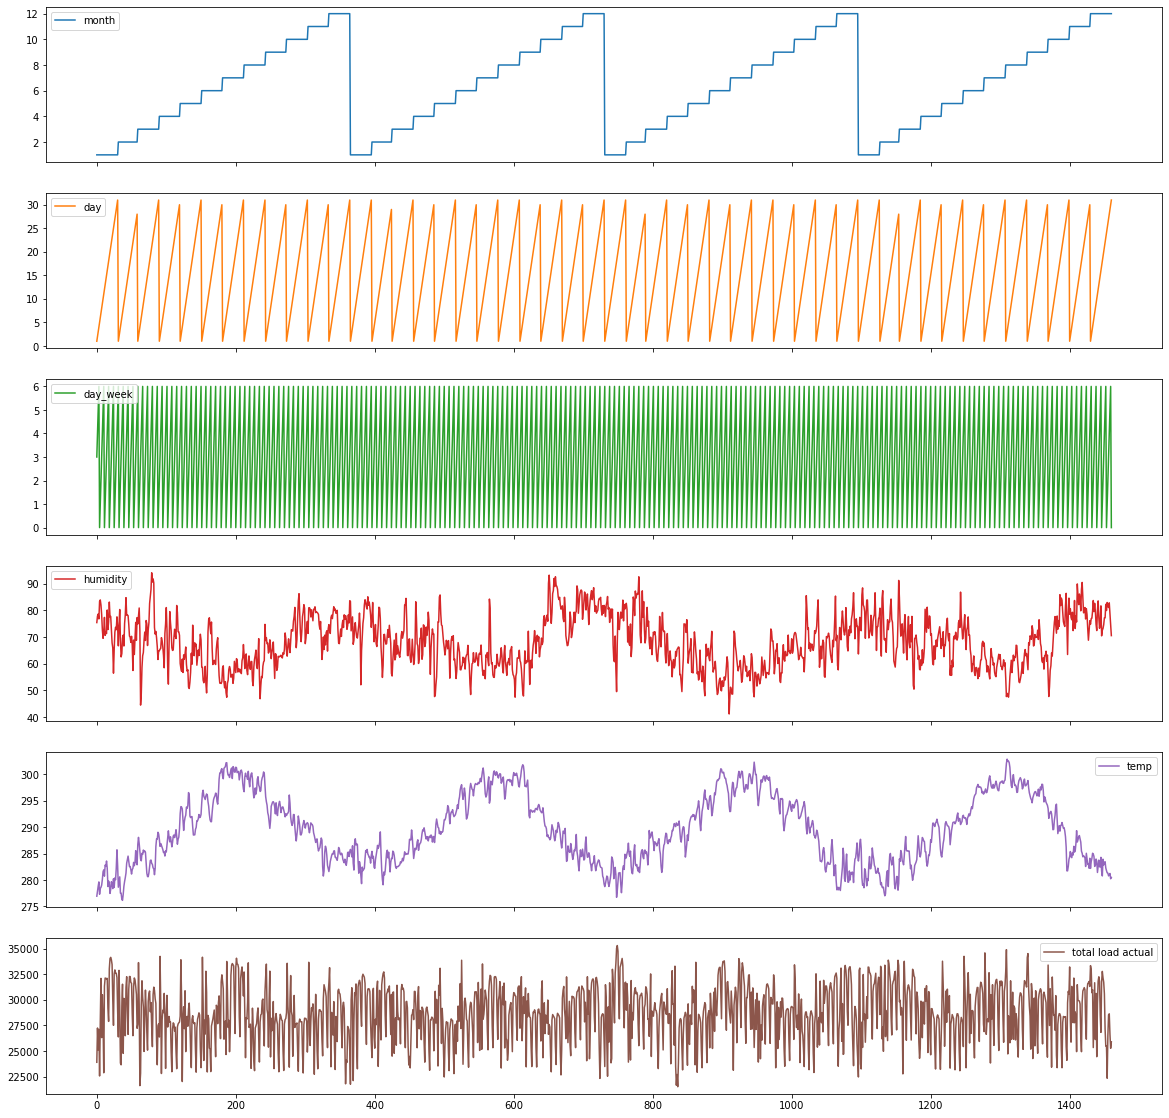

In [12]:
# plot for each column
df.plot(figsize=(20, 20), subplots=True)

### 1.2 Remove outliers in the energy consumption column
For the energy consumption, the outliers are detected using a rolling basis.


In [13]:
# code from https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d

# window size = 14 days
def basic_filter(data, mode='rolling', window=14, threshold=2):
    """Basic Filter.
    
    Mark as outliers the points that are out of the interval:
    (mean - threshold * std, mean + threshold * std ).
    
    Parameters
    ----------
    data : pandas.Series
        The time series to filter.
    mode : str, optional, default: 'rolling'
        Whether to filter in rolling or expanding basis.
    window : int, optional, default: 262
        The number of periods to compute the mean and standard
        deviation.
    threshold : int, optional, default: 3
        The number of standard deviations above the mean.
        
    Returns
    -------
    series : pandas.DataFrame
        Original series and marked outliers.
    """
    msg = f"Type must be of pandas.Series but {type(data)} was passed."
    assert isinstance(data, pd.Series), msg
    
    series = data.copy()
    
    # rolling/expanding objects
    pd_object = getattr(series, mode)(window=window)
    mean = pd_object.mean()
    std = pd_object.std()
    
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    outliers = ~series.between(lower_bound, upper_bound)
    # fill false positives with 0
    outliers.iloc[:window] = np.zeros(shape=window)
    
    series = series.to_frame()
    series['outliers'] = np.array(outliers.astype('int').values)
    series.columns = ['Close', 'Outliers']
    
    return series

In [14]:
# check if the energy value is an outlier
energy_outliers = basic_filter(df['total load actual'])

# add the outlier column to the df_no_outliers dataframe
df['load_outlier'] = energy_outliers['Outliers']

df

month  day  day_week   humidity        temp  total load actual  \
0         1    1         3  75.391667  276.928845       23896.750000   
1         1    2         4  77.833333  277.897585       27251.291667   
2         1    3         5  78.591667  278.817864       25110.666667   
3         1    4         6  76.766667  279.630031       27112.625000   
4         1    5         0  83.322222  277.302399       22559.444444   
...     ...  ...       ...        ...         ...                ...   
1456     12   27         3  81.030556  280.774514       28532.208333   
1457     12   28         4  82.788889  280.972111       28637.750000   
1458     12   29         5  78.708333  281.231583       26636.750000   
1459     12   30         6  74.272222  280.229097       25263.916667   
1460     12   31         0  70.506944  280.476750       25897.250000   

      load_outlier  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
1456             0  
1457             0  
1458             0  
1459             0  
1460             0  

[1461 rows x 7 columns]

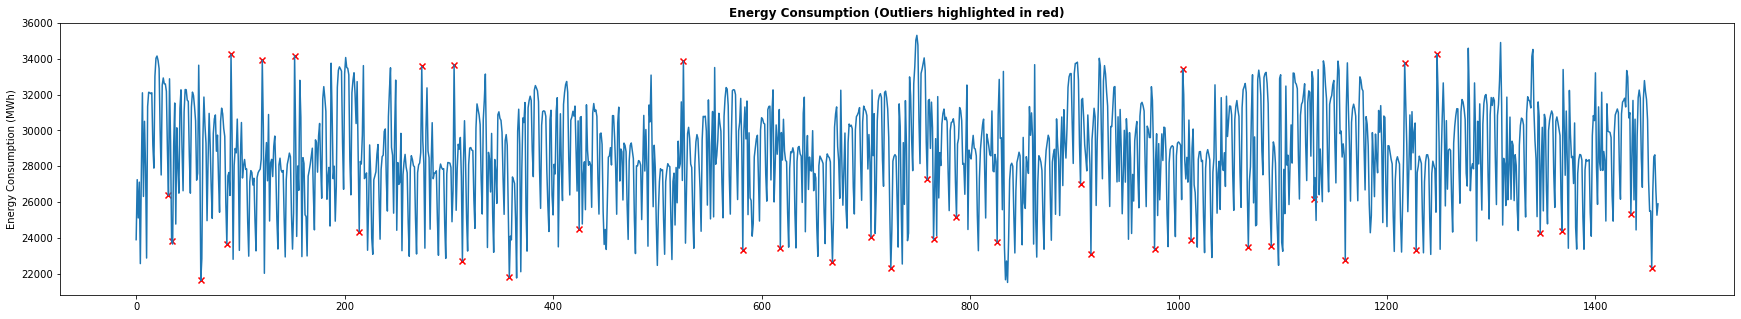

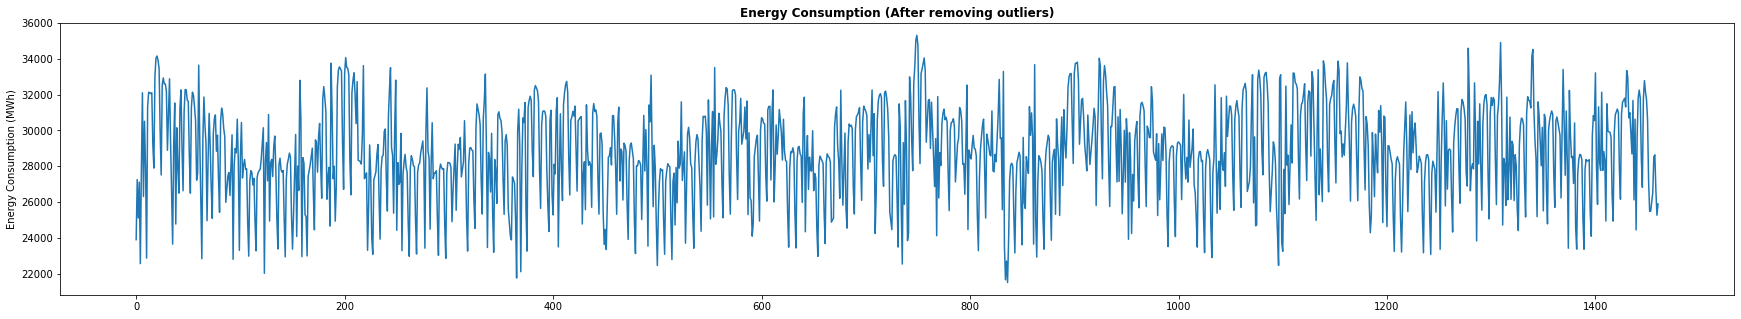

In [15]:
# show the outlier in plot
plt.figure(figsize=(30, 5))
plt.plot(df["total load actual"])

outliers = df["load_outlier"]
plt.scatter(df.loc[outliers == 1].index, df.loc[outliers == 1]["total load actual"], c = 'red', marker="x")
plt.ylabel("Energy Consumption (MWh)")
plt.title("Energy Consumption (Outliers highlighted in red)", fontweight="bold")
plt.show()

# select only non-outlier data
df = df.loc[df['load_outlier'] == 0]

# show data after removing outlier
plt.figure(figsize=(30, 5))
plt.plot(df["total load actual"])
plt.ylabel("Energy Consumption (MWh)")
plt.title("Energy Consumption (After removing outliers)", fontweight="bold")
plt.show()


### 1.3 Remove noise using Fourier Transform

In [16]:
if DENOISE:
    def fft_denoiser(x, n_components, to_real=True):
        """Fast fourier transform denoiser.
        
        Denoises data using the fast fourier transform.
        
        Parameters
        ----------
        x : numpy.array
            The data to denoise.
        n_components : int
            The value above which the coefficients will be kept.
        to_real : bool, optional, default: True
            Whether to remove the complex part (True) or not (False)
            
        Returns
        -------
        clean_data : numpy.array
            The denoised data.
            
        References
        ----------
        .. [1] Steve Brunton - Denoising Data with FFT[Python]
        https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
        
        """
        n = len(x)
        
        # compute the fft
        fft = np.fft.fft(x, n)
        
        # compute energy spectrum density
        # squared magnitud of each fft coefficient
        PSD = fft * np.conj(fft) / n
        
        # keep high frequencies
        _mask = PSD > n_components
        fft = _mask * fft
        
        # inverse fourier transform
        clean_data = np.fft.ifft(fft)
        
        if to_real:
            clean_data = clean_data.real
        
        return clean_data

/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/ceciliali/opt/anaconda3/envs/neuralcomputing/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


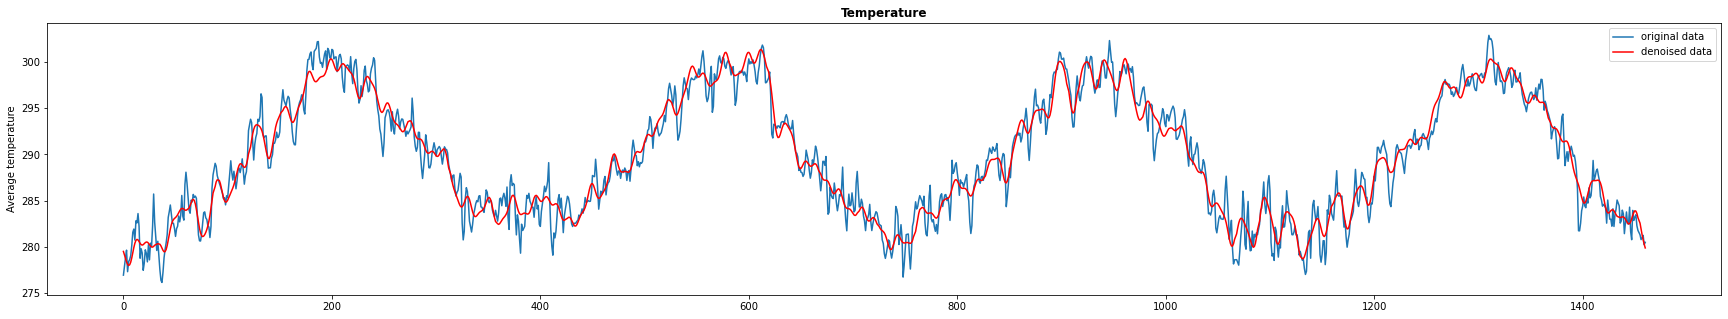

<ipython-input-17-273d6e0d5183>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['denoised_data_humidity'] = denoised_humidity


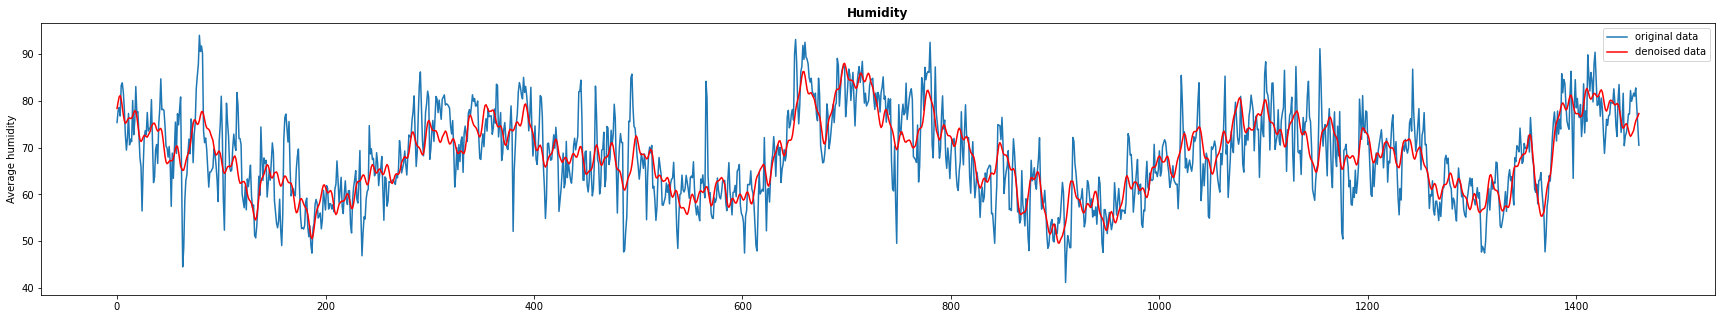

<ipython-input-17-273d6e0d5183>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['denoised_data_load'] = denoised_load


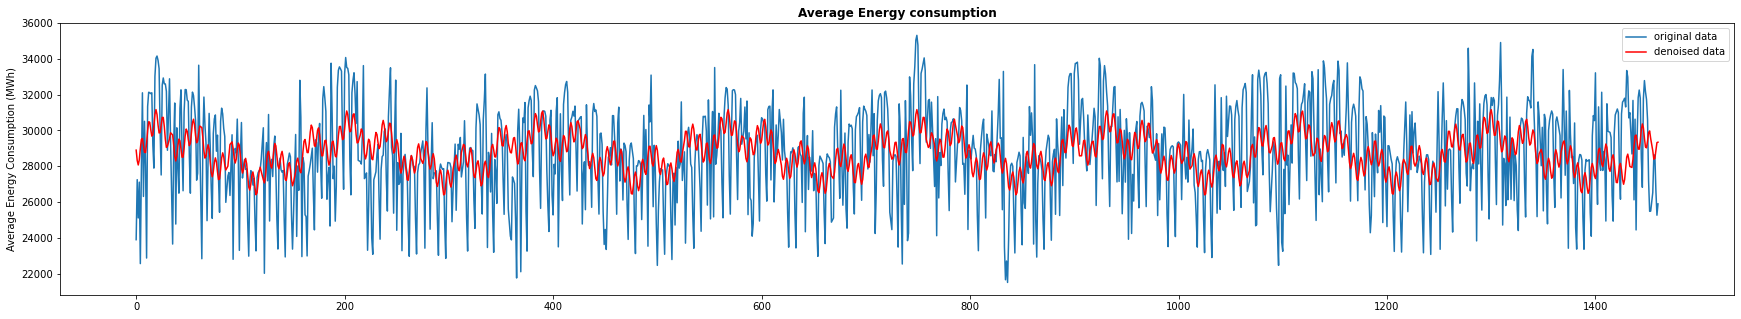

In [17]:
if DENOISE:
    # remove noise in temperature 
    denoised_temp = fft_denoiser(df['temp'], 25)
    df.loc[:, 'denoised_data_temp'] = denoised_temp

    # show the original and denoised data
    plt.figure(figsize=(30, 5))
    plt.plot(df['temp'], label='original data')
    plt.plot(df['denoised_data_temp'], color='r', label = "denoised data")
    plt.ylabel("Average temperature")
    plt.title("Temperature", fontweight="bold")
    plt.legend()
    plt.show()

    # remove noise in humidity 
    denoised_humidity = fft_denoiser(df['humidity'],300)
    df['denoised_data_humidity'] = denoised_humidity
    df

    # show the original and denoised data
    plt.figure(figsize=(30, 5))
    plt.plot(df['humidity'], label='original data')
    plt.plot(df['denoised_data_humidity'], color='r', label = "denoised data")
    plt.ylabel("Average humidity")
    plt.title("Humidity", fontweight="bold")
    plt.legend()
    plt.show()

    # remove noise in energy consumption 
    denoised_load = fft_denoiser(df['total load actual'], 145000000)
    df['denoised_data_load'] = denoised_load
    df


    # show the original and denoised data
    plt.figure(figsize=(30, 5))
    plt.plot(df['total load actual'], label='original data')
    plt.plot(df['denoised_data_load'], color='r', label = "denoised data")
    plt.ylabel("Average Energy Consumption (MWh)")
    plt.title("Average Energy consumption", fontweight="bold")
    plt.legend()
    plt.show()

In [18]:
if DENOISE:
    df = df.drop(['total load actual', 'temp', 'humidity', 'load_outlier'], axis=1)     # if the denoised data are used, the original columns can be dropped
    df

In [19]:
if not DENOISE:
    df = df.drop(['load_outlier'], axis=1)  # if the original noisy data are used, drop the outlier column
    df

In [222]:
df_clean = df.copy()
df_clean = df_clean.reset_index(drop=True)     # reset index so that the plots thereafter have the correct x axis values
df_clean


month  day  day_week  denoised_data_temp  denoised_data_humidity  \
0         1    1         3          279.491020               78.392197   
1         1    2         4          279.110262               79.736353   
2         1    3         5          278.727997               80.838707   
3         1    4         6          278.373749               81.150555   
4         1    5         0          278.102647               80.417314   
...     ...  ...       ...                 ...                     ...   
1417     12   27         3          281.913990               74.807485   
1418     12   28         4          281.296557               75.699231   
1419     12   29         5          280.748508               76.242194   
1420     12   30         6          280.280294               76.657099   
1421     12   31         0          279.872257               77.307731   

      denoised_data_load  
0           28900.448644  
1           28323.259655  
2           28071.530600  
3           28359.995469  
4           28988.436406  
...                  ...  
1417        28396.755304  
1418        28438.090703  
1419        28887.109770  
1420        29322.482935  
1421        29345.208483  

[1422 rows x 6 columns]

In [223]:
# create labels
# add a column for the energy consumption, but swifted a day up
df_clean['label'] = df_clean.iloc[:, -1]
df_clean['label'] = df_clean['label'].shift(-1)

# delete the last row because it has no label
df_clean = df_clean.iloc[:-1, :]
df_clean

month  day  day_week  denoised_data_temp  denoised_data_humidity  \
0         1    1         3          279.491020               78.392197   
1         1    2         4          279.110262               79.736353   
2         1    3         5          278.727997               80.838707   
3         1    4         6          278.373749               81.150555   
4         1    5         0          278.102647               80.417314   
...     ...  ...       ...                 ...                     ...   
1416     12   26         2          282.554654               73.686217   
1417     12   27         3          281.913990               74.807485   
1418     12   28         4          281.296557               75.699231   
1419     12   29         5          280.748508               76.242194   
1420     12   30         6          280.280294               76.657099   

      denoised_data_load         label  
0           28900.448644  28323.259655  
1           28323.259655  28071.530600  
2           28071.530600  28359.995469  
3           28359.995469  28988.436406  
4           28988.436406  29501.673994  
...                  ...           ...  
1416        28866.668457  28396.755304  
1417        28396.755304  28438.090703  
1418        28438.090703  28887.109770  
1419        28887.109770  29322.482935  
1420        29322.482935  29345.208483  

[1421 rows x 7 columns]

### 1.4 Standardize the data

In [224]:
# standardize the data so that all values lie between 0 and 1

scaler = MinMaxScaler(feature_range = (0, 1))
df_clean = pd.DataFrame(scaler.fit_transform(df_clean), index=df_clean.index, columns=df_clean.columns)

### 1.5 Split the dataset to training, validation and test set

In [225]:
# split the data into 70% training, 10% validation and 20% test set
# manually split the data to avoid shuffling the data
train_idx = int(len(df_clean)*0.7)
validation_idx = int(len(df_clean)*0.8)


train_data = df_clean.iloc[:train_idx]
validation_data = df_clean.iloc[train_idx:validation_idx]
test_data = df_clean.iloc[validation_idx:]

print("training set sample size is", len(train_data))
print("validation set sample size is", len(validation_data))
print("test set sample size is", len(test_data))

print("total sample size is", len(train_data)+ len(validation_data) +len(test_data))

training set sample size is 994
validation set sample size is 142
test set sample size is 285
total sample size is 1421


In [226]:
# export the test data for test run in marking
test_data.to_csv('test_data.csv')

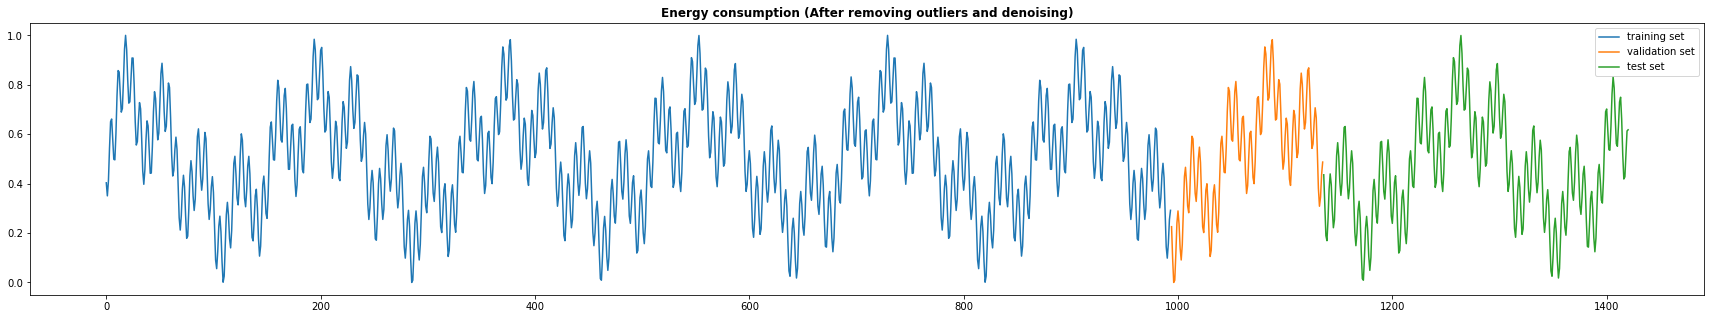

In [227]:
# plot the labels for training, validation and test set in different colours
plt.figure(figsize=(30, 5))
plt.plot(train_data['label'], label='training set')
plt.plot(np.arange(train_data.shape[0], train_data.shape[0] + validation_data.shape[0]), validation_data['label'], label='validation set')
plt.plot(np.arange(train_data.shape[0] + validation_data.shape[0], train_data.shape[0] + validation_data.shape[0]+test_data.shape[0]), test_data['label'], label='test set')
plt.legend()
plt.title('Energy consumption (After removing outliers and denoising)', fontweight='bold')
plt.show()

### 1.6 Give each instance a sequence of observations

In [228]:
# functions to create sequence of observations (lag the features)
# each instance will have number of observations = sequence_length

# code adapted from https://www.youtube.com/watch?v=jR0phoeXjrc

# function to create list, with each element containing sequence_length of observations
def create_feature(input_data: pd.DataFrame, sequence_length):

    feature = []
    data_size = len(input_data)

    input_data = input_data.iloc[:, :-1]
    
    for i in range(data_size - sequence_length):
        
        sequence = input_data[i:i+sequence_length]

        feature.append(sequence)

    return feature

# function to create labels for each element of the create_feature list
def create_label(input_data: pd.DataFrame, target_column, sequence_length):

    labels = []
    data_size = len(input_data)

    for i in range(data_size - sequence_length):

        # sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        labels.append(label)

    return labels

In [229]:
# SEQUENCE_LENGTH can be changed at the top of the notebook
# lag the training set
train_feature = create_feature(train_data, sequence_length = SEQUENCE_LENGTH)
train_label = create_label(train_data, "label", sequence_length = SEQUENCE_LENGTH)

# lag the validation set
validation_feature = create_feature(validation_data, sequence_length=SEQUENCE_LENGTH)
validation_label = create_label(validation_data, "label", sequence_length=SEQUENCE_LENGTH)

# lag the test set
test_feature = create_feature(test_data, sequence_length=SEQUENCE_LENGTH)
test_label = create_label(test_data, "label", sequence_length=SEQUENCE_LENGTH)

In [216]:
print("Length of train_feature is ", str(len(train_feature)))
print("Length of train_label is ", str(len(train_label)))
print("Length of validation_feature is ", str(len(validation_feature)))
print("Length of validation_label is ", str(len(validation_label)))
print("Length of test_feature is ", str(len(test_feature)))
print("Length of test_label is ", str(len(test_label)))


Length of train_feature is  987
Length of train_label is  987
Length of validation_feature is  135
Length of validation_label is  135
Length of test_feature is  278
Length of test_label is  278


### 1.7 Check whether it is running on CPU or GPU

In [217]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


## Part 2 - Simple MLP

Since MLP only takes a 1D tensor for the input, the tensors have to be flattened to fit into MLP model

In [218]:
# convert the training_feature list to tensor
X_train_MLP = torch.tensor(np.array(train_feature), dtype=torch.float)
# flatten the tensor
X_train_MLP = torch.flatten(X_train_MLP, start_dim=1)
print("The shape of the X_train_MLP tensor is ", str(X_train_MLP.shape))

# convert the training_label list to tensor
y_train_MLP = torch.FloatTensor(train_label)
print("The shape of the y_train_MLP tensor is ", str(y_train_MLP.shape))

# convert the validation_feature list to tensor
X_validation_MLP = torch.tensor(np.array(validation_feature), dtype=torch.float)
# flatten the tensor
X_validation_MLP = torch.flatten(X_validation_MLP, start_dim=1)
print("The shape of the X_validation_MLP tensor is ", str(X_validation_MLP.shape))

# convert the training_label list to tensor
y_validation_MLP = torch.FloatTensor(validation_label)
print("The shape of the y_validation_MLP tensor is ", str(y_validation_MLP.shape))

# convert the test_feature list to tensor
X_test_MLP = torch.tensor(np.array(test_feature), dtype=torch.float)
# flatten the tensor
X_test_MLP = torch.flatten(X_test_MLP, start_dim=1)
print("The shape of the X_test_MLP tensor is ", str(X_test_MLP.shape))

# convert the test_label list to tensor
y_test_MLP = torch.FloatTensor(test_label)
print("The shape of the y_test_MLP tensor is ", str(y_test_MLP.shape))

The shape of the X_train_MLP tensor is  torch.Size([987, 42])
The shape of the y_train_MLP tensor is  torch.Size([987])
The shape of the X_validation_MLP tensor is  torch.Size([135, 42])
The shape of the y_validation_MLP tensor is  torch.Size([135])
The shape of the X_test_MLP tensor is  torch.Size([278, 42])
The shape of the y_test_MLP tensor is  torch.Size([278])


### 2.1 Simple MLP without optimisation

In [95]:
# create a MLP class
# code from week 2 lab

class MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

In [82]:
# get an instance of the MLP
mlp_model = MLP(input_size = X_train_MLP.shape[1], hidden_dim = 40, output_size=1)    # shape of X_train_MLP = (987, 42)

In [83]:
# define some parameters for the MLP
lr = 0.01    # learning rate
n_epoch = 100   # number of epochs
momentum = 0.95  # momentum term

criterion = nn.MSELoss()    # specify loss function as mean-squared error
optimizer = torch.optim.SGD(mlp_model.parameters(), lr, momentum)   # optimise using stochastic gradient descent

Epoch 0/100 - Loss: 0.60247403383255
Epoch 10/100 - Loss: 0.13207633793354034
Epoch 20/100 - Loss: 0.1478317379951477
Epoch 30/100 - Loss: 0.11230270564556122
Epoch 40/100 - Loss: 0.06518349051475525
Epoch 50/100 - Loss: 0.06188294291496277
Epoch 60/100 - Loss: 0.04862035810947418
Epoch 70/100 - Loss: 0.03957460820674896
Epoch 80/100 - Loss: 0.03966360166668892
Epoch 90/100 - Loss: 0.03172454610466957


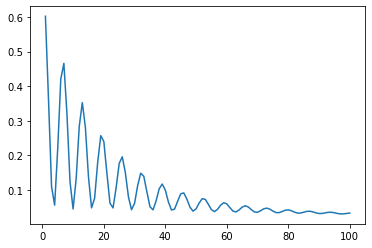

In [84]:
mlp_model.train()  # enter train mode

loss_list = []

for epoch in range(n_epoch):
    optimizer.zero_grad()   # reset gradient
    y_pred = mlp_model(X_train_MLP)     # get predicted value
    loss = criterion(y_pred.squeeze(), y_train_MLP)     # calculate the loss   
    loss.backward()     # backpropagation
    optimizer.step()    # update the parameters
    loss_list.append(loss.detach().numpy())


    if epoch%10 == 0:
        print('Epoch {}/{} - Loss: {}'.format(epoch, n_epoch, loss.item()))

plt.plot(np.arange(1, 101), loss_list)
plt.show()


In [85]:
mlp_model.eval()    # enter evaluation mode
y_pred = mlp_model(X_validation_MLP)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation_MLP)    # compare predicted and target value using the criterion 
print('loss after training' , after_train.item())    

loss after training 0.022824198007583618


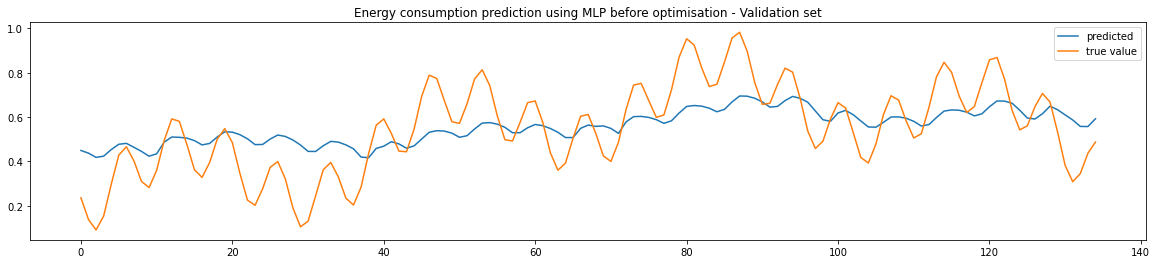

In [86]:
# compare the predicted and true value
plt.figure(figsize=(20, 4))
plt.plot(y_pred.detach().numpy(), label='predicted')
plt.plot(y_validation_MLP, label='true value')
plt.title("Energy consumption prediction using MLP before optimisation - Validation set")
plt.legend()
plt.show()

### 2.2 Grid search with cross validation

In [87]:
# time series cross validation for time series data
tscv = TimeSeriesSplit(n_splits = 10, test_size=20, gap = 10)

In [88]:
# add one more dimension to the y_train_MLP tensor to fit into the grid search
y_train_MLP_2D = y_train_MLP[:, None]
y_train_MLP_2D.shape

torch.Size([987, 1])

In [89]:
# new instance for MLP
MLP_GS = MLP(input_size = X_train_MLP.shape[1], hidden_dim = 40, output_size=1)

net_mlp = NeuralNetRegressor(module = MLP_GS, train_split=False)  


params = {'lr': [0.01, 0.05, 0.1],
        'max_epochs': [20, 40],
        'optimizer': [torch.optim.SGD, torch.optim.Adam],
        'batch_size': [16, 32, 64]}

tt0 = time.time()       # start the timer
gs = GridSearchCV(net_mlp, params, scoring='neg_mean_squared_error', refit=True, cv=tscv, verbose=0)
gs.fit(X_train_MLP, y_train_MLP_2D)
tt1 = time.time()       # stop the timer
print(gs.best_params_)
print("The total time for the grid search is ", str(tt1 - tt0))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0626  0.0312
      2        0.0469  0.0313
      3        0.0463  0.0305
      4        0.0457  0.0301
      5        0.0451  0.0385
      6        0.0445  0.0347
      7        0.0440  0.0307
      8        0.0434  0.0297
      9        0.0429  0.0298
     10        0.0423  0.0301
     11        0.0418  0.0302
     12        0.0413  0.0308
     13        0.0408  0.0298
     14        0.0403  0.0302
     15        0.0398  0.0310
     16        0.0393  0.0299
     17        0.0389  0.0301
     18        0.0384  0.0305
     19        0.0379  0.0303
     20        0.0375  0.0298
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0620  0.0324
      2        0.0467  0.0360
      3        0.0461  0.0351
      4        0.0455  0.0313
      5        0.0449  0.0334
      6        0.0443  0.0358
      7        0.0437  0.0354
      8        0.0432  0.0356
      9        0.0426  0.0351
     10   

In [90]:
print("Result of grid search returns the best model as {} with a mean squared error of {:.6f}".format(gs.best_params_, -gs.best_score_))
gs.best_params_

Result of grid search returns the best model as {'batch_size': 64, 'lr': 0.05, 'max_epochs': 40, 'optimizer': <class 'torch.optim.adam.Adam'>} with a mean squared error of 0.010532


{'batch_size': 64,
 'lr': 0.05,
 'max_epochs': 40,
 'optimizer': torch.optim.adam.Adam}

The mean squared error for Training set is  0.014253474
The root mean squared error for Training set is  0.11938791
The mean absolute error for Training set is  0.10059929


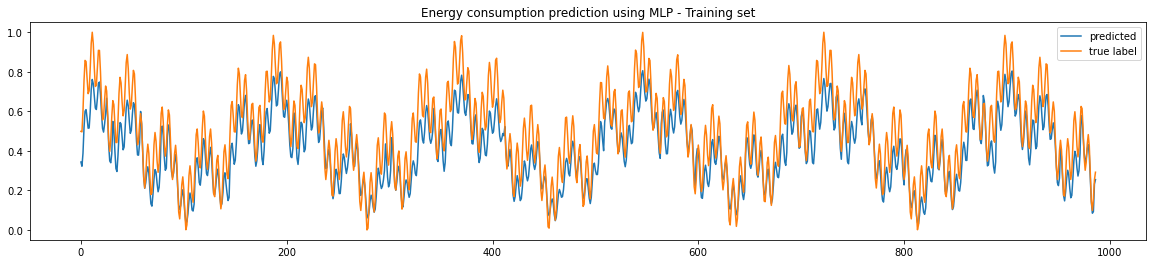

The mean squared error for Validation set is  0.018925445
The root mean squared error for Validation set is  0.13756979
The mean absolute error for Validation set is  0.123735934


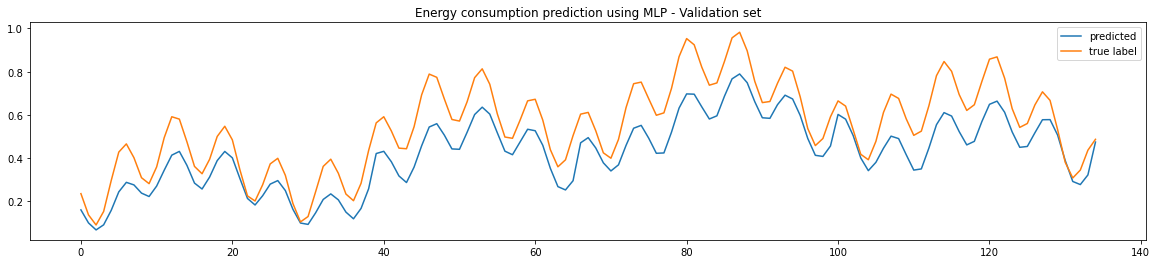

In [91]:
set = ['Training set', 'Validation set', 'Test set']
true_label = [y_train_MLP, y_validation_MLP]
features = [X_train_MLP, X_validation_MLP]

for i in range(len(true_label)):
    y_pred = gs.predict(features[i])
    print("The mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i]))
    print("The root mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i], squared=False))
    print("The mean absolute error for {} is ".format(set[i]), mean_absolute_error(y_pred, true_label[i]))
    plt.figure(figsize=(20, 4))
    plt.plot(y_pred, label='predicted')
    plt.plot(true_label[i], label='true label')
    plt.title('Energy consumption prediction using MLP - ' + str(set[i]))
    plt.legend()
    plt.show()


### 2.3 Train the best MLP with hyperparameters from the grid search

In [92]:
# prepare the data in batches for the model
BATCH_SIZE = 64

# create batched dataset
train_MLP = TensorDataset(X_train_MLP, y_train_MLP_2D)
train_loader_MLP = DataLoader(train_MLP, batch_size = BATCH_SIZE, shuffle=False, drop_last=True)

# check the shapes of the input and output tensors in training set
X, y = next(iter(train_loader_MLP))
print(X.shape)
print(y.shape)

torch.Size([64, 42])
torch.Size([64, 1])


In [96]:
# new stance for the MLP with best parameters
MLP_best = MLP(input_size = X_train_MLP.shape[1], hidden_dim = 40, output_size=1)

# define some parameters for the MLP
lr = 0.05    # learning rate
n_epoch = 200   # number of epochs  # readjusted from 40 to 200 
criterion = nn.MSELoss()    # specify loss function as mean-squared error
optimizer = torch.optim.Adam(MLP_best.parameters())   # optimise using stochastic gradient descent

MLP_best.train()  # enter train mode

tt0 = time.time()   # start the timer

# Training Run
for epoch in range(n_epoch):
    for X, y in train_loader_MLP:
        optimizer.zero_grad()   # reset gradient
        y_pred = MLP_best(X)     # get predicted value
        loss = criterion(y_pred, y)     # calculate the loss   
        loss.backward()     # backpropagation
        optimizer.step()    # update the parameters

    if epoch%10 == 0:
        print('Epoch {}/{} - Loss: {}'.format(epoch, n_epoch, loss.item()))

tt1 = time.time()   # stop the timer
print("The total training time is ", str(tt1-tt0))


Epoch 0/200 - Loss: 0.042880211025476456
Epoch 10/200 - Loss: 0.03236750513315201
Epoch 20/200 - Loss: 0.021164191886782646
Epoch 30/200 - Loss: 0.016086582094430923
Epoch 40/200 - Loss: 0.014090137556195259
Epoch 50/200 - Loss: 0.013201151974499226
Epoch 60/200 - Loss: 0.012643246911466122
Epoch 70/200 - Loss: 0.012143366038799286
Epoch 80/200 - Loss: 0.01161595806479454
Epoch 90/200 - Loss: 0.01103382557630539
Epoch 100/200 - Loss: 0.010386700741946697
Epoch 110/200 - Loss: 0.00967354141175747
Epoch 120/200 - Loss: 0.00890518818050623
Epoch 130/200 - Loss: 0.008107192814350128
Epoch 140/200 - Loss: 0.007308617699891329
Epoch 150/200 - Loss: 0.0065034301951527596
Epoch 160/200 - Loss: 0.005627716891467571
Epoch 170/200 - Loss: 0.004673313815146685
Epoch 180/200 - Loss: 0.003764806780964136
Epoch 190/200 - Loss: 0.0029759900644421577
The total training time is  2.9930193424224854


In [138]:
# evaluate on validation set
MLP_best.eval()
y_pred = MLP_best(X_validation_MLP)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation_MLP)    # compare predicted and target value using the criterion 
print('loss in validation set after training' , after_train.item())    


loss in validation set after training 0.002263349946588278


The mean squared error for Training set is  0.00256045
The root mean squared error for Training set is  0.05060089
The mean absolute error for Training set is  0.042364288


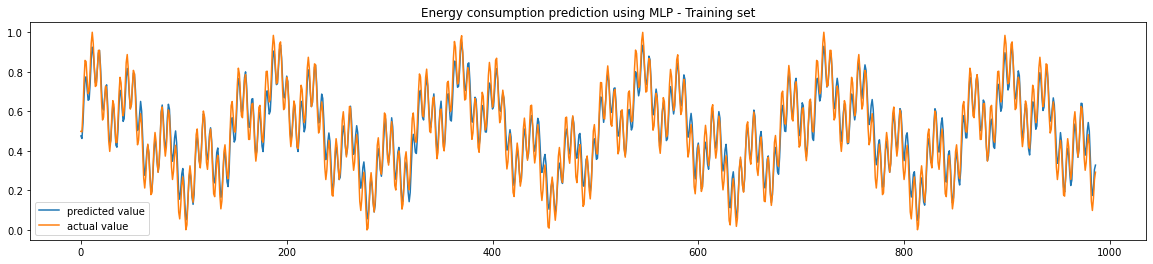

The mean squared error for Validation set is  0.00226335
The root mean squared error for Validation set is  0.047574677
The mean absolute error for Validation set is  0.039018497


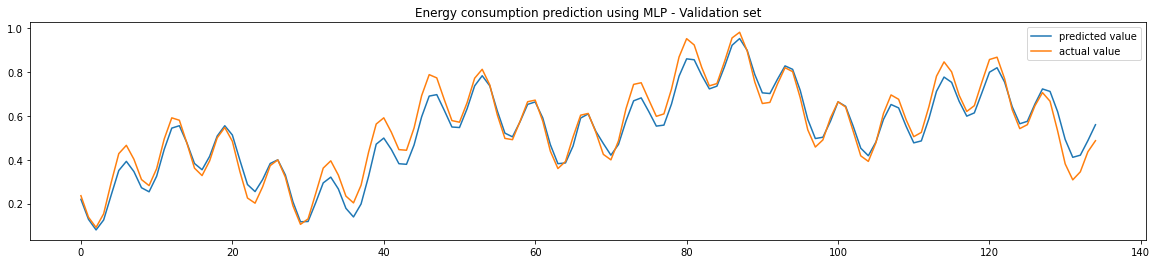

The mean squared error for Test set is  0.002919002
The root mean squared error for Test set is  0.05402779
The mean absolute error for Test set is  0.044441137


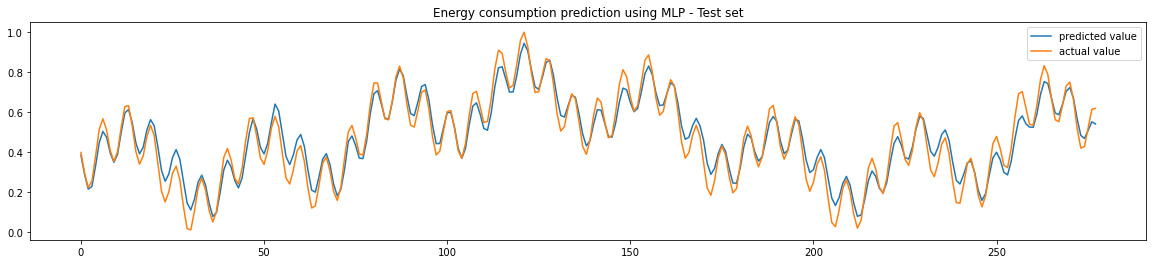

In [185]:
# display the results
set = ['Training set', 'Validation set', 'Test set']
true_label = [y_train_MLP, y_validation_MLP, y_test_MLP]
features = [X_train_MLP, X_validation_MLP, X_test_MLP]

for i in range(len(true_label)):
    y_pred = MLP_best(features[i])
    print("The mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred.detach().numpy(), true_label[i]))
    print("The root mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred.detach().numpy(), true_label[i], squared=False))
    print("The mean absolute error for {} is ".format(set[i]), mean_absolute_error(y_pred.detach().numpy(), true_label[i]))
    plt.figure(figsize=(20, 4))
    plt.plot(y_pred.detach().numpy(), label='predicted value')
    plt.plot(true_label[i], label='actual value')
    plt.title('Energy consumption prediction using MLP - ' + str(set[i]))
    plt.legend()
    plt.show()

In [188]:
# save the best MLP model
torch.save(MLP_best, 'MLP.pth')

# Part 3 - RNN

The input tensor should not be flattened for RNN, because RNN has an input of sequence length. Recreate the training, validation and test set for the RNN.

In [202]:
# create tensor containing the lagged feature for training set 
train_feature = np.array([np.array(xi) for xi in train_feature])    # convert the list of list to a numpy array
X_train_RNN = torch.Tensor(train_feature)   # create the tensor

# create tensor for the label of training set 
y_train_RNN = torch.Tensor(np.array(train_label))   # convert the list of label to an numpy array, then to a tensor
y_train_RNN = torch.unsqueeze(y_train_RNN, 1)   # add a dimension of size one to the tensor

# create tensor containing the lagged feature for validation set 
X_validation_RNN = np.array([np.array(xi) for xi in validation_feature])    # convert the list of list to a numpy array
X_validation_RNN = torch.Tensor(X_validation_RNN)   # create the tensor

# create tensor for the label of validation set 
y_validation_RNN = torch.Tensor(np.array(validation_label))   # convert the list of label to an numpy array, then to a tensor
y_validation_RNN = torch.unsqueeze(y_validation_RNN, 1)  # add a dimension of size one to the tensor

# create tensor containing the lagged feature for test set 
X_test_RNN = np.array([np.array(xi) for xi in test_feature])      # convert the list of list to a numpy array
X_test_RNN = torch.Tensor(X_test_RNN)    # create the tensor

# create tensor for the label of test set 
y_test_RNN = torch.Tensor(np.array(test_label))  # convert the list of label to an numpy array, then to a tensor
y_test_RNN = torch.unsqueeze(y_test_RNN, 1)  # add a dimension of size one to the tensor

In [203]:
X_test_RNN.size()

torch.Size([278, 7, 7])

### 3.1 Simple RNN without optimisation

In [181]:
# create RNN class
# code adopted from week 10 lab
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(RNN, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # RNN layers
        self.rnn = nn.RNN(input_size, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

Epoch: 10/100............. Loss: 0.1272
Epoch: 20/100............. Loss: 0.0785
Epoch: 30/100............. Loss: 0.0392
Epoch: 40/100............. Loss: 0.0327
Epoch: 50/100............. Loss: 0.0372
Epoch: 60/100............. Loss: 0.0320
Epoch: 70/100............. Loss: 0.0255
Epoch: 80/100............. Loss: 0.0236
Epoch: 90/100............. Loss: 0.0229
Epoch: 100/100............. Loss: 0.0220


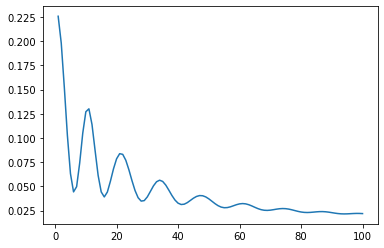

In [156]:
# Instantiate the model with hyperparameters
RNN_model = RNN(input_size=X.size(2), output_size=1, hidden_dim=40, num_layers=1)

# Define hyperparameters
n_epochs = 100
lr=0.01
momentum = 0.95

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(RNN_model.parameters(), lr=lr, momentum=momentum)

RNN_model.train()    # training mode

loss_list = []

# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    output = RNN_model(X_train_RNN)
    output = output.to(device)

    loss = criterion(output, y_train_RNN)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    loss_list.append(loss.detach().numpy())

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

plt.plot(np.arange(1, 101), loss_list)
plt.show()


In [119]:
RNN_model.eval()    # enter evaluation mode

y_pred = RNN_model(X_validation_RNN)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation_RNN.squeeze())    # compare predicted and target value using the criterion 
print('loss after training' , after_train.item())    

loss after training 0.023113777860999107


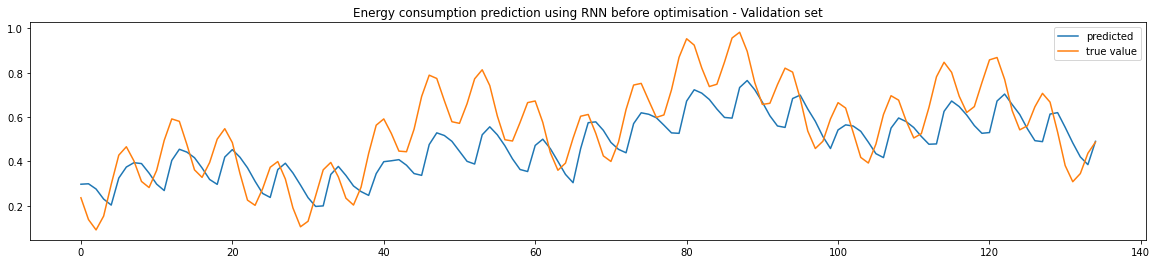

In [120]:
# compare the predicted and true value
plt.figure(figsize=(20, 4))
plt.plot(y_pred.detach().numpy(), label='predicted')
plt.plot(y_validation_RNN, label='true value')
plt.title("Energy consumption prediction using RNN before optimisation - Validation set")
plt.legend()
plt.show()

### 3.2 Grid search with cross validation

In [121]:
# time series cross validation for time series data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 10, test_size=20, gap = 10)

In [122]:
# new instance for RNN
RNN_GS = RNN(input_size=X.size(2), output_size=1, hidden_dim=40, num_layers=1)

net_rnn = NeuralNetRegressor(module = RNN_GS, train_split=False)  

params = {'lr': [0.01, 0.05, 0.1],
        'max_epochs': [20, 40],
        'optimizer': [torch.optim.SGD, torch.optim.Adam],
        'batch_size': [16, 32, 64]}

tt0 = time.time()       # start the timer

gs_RNN = GridSearchCV(net_rnn, params, scoring='neg_mean_squared_error', refit=True, cv=tscv, verbose=0)        # specify the grid search
gs_RNN.fit(X_train_RNN, y_train_RNN)    # fit the data to the grid search

tt1 = time.time()       # stop the timer
print(gs_RNN.best_params_)
print('Total time for grid search = ', str(tt1 - tt0))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0705  0.0683
      2        0.0403  0.0645
      3        0.0382  0.0644
      4        0.0363  0.0605
      5        0.0346  0.0615
      6        0.0330  0.0588
      7        0.0316  0.0617
      8        0.0303  0.0609
      9        0.0290  0.0621
     10        0.0279  0.0597
     11        0.0269  0.0615
     12        0.0260  0.0579
     13        0.0251  0.0633
     14        0.0244  0.0616
     15        0.0236  0.0590
     16        0.0230  0.0626
     17        0.0224  0.0635
     18        0.0219  0.0633
     19        0.0215  0.0611
     20        0.0211  0.0571
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0695  0.0564
      2        0.0401  0.0619
      3        0.0380  0.0619
      4        0.0361  0.0641
      5        0.0343  0.0616
      6        0.0327  0.0601
      7        0.0313  0.0611
      8        0.0299  0.0644
      9        0.0287  0.0615
     10   

In [123]:
print("Result of grid search returns the best model as {} with a mean squared error of {:.6f}".format(gs_RNN.best_params_, -gs_RNN.best_score_))

Result of grid search returns the best model as {'batch_size': 64, 'lr': 0.01, 'max_epochs': 40, 'optimizer': <class 'torch.optim.adam.Adam'>} with a mean squared error of 0.001079


In [124]:
# test the loss on validation set
y_pred_best = gs_RNN.predict(X_validation_RNN)
mean_squared_error(y_pred_best, y_validation_RNN)  

0.00058056955

The mean squared error for Training set is  0.0006406897
The root mean squared error for Training set is  0.025311848
The mean absolute error for Training set is  0.020923741


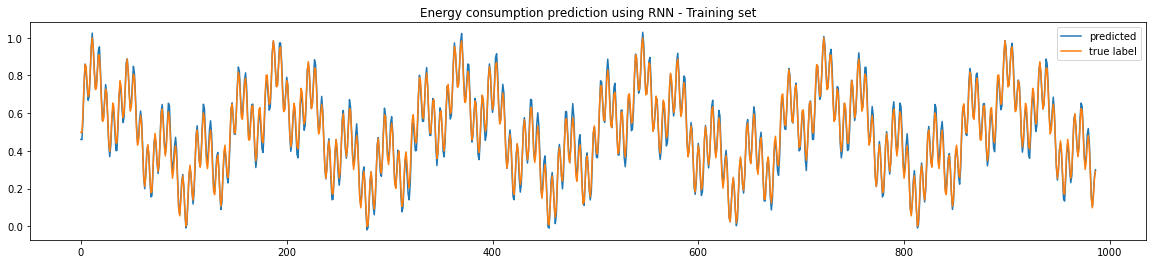

The mean squared error for Validation set is  0.00058056955
The root mean squared error for Validation set is  0.024095012
The mean absolute error for Validation set is  0.019903908


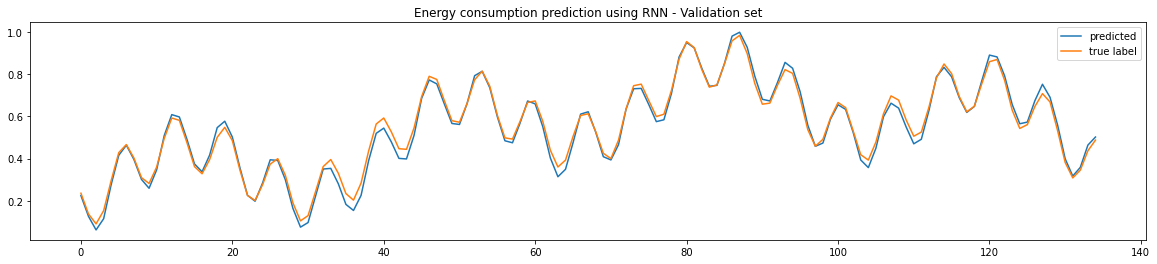

In [125]:
set = ['Training set', 'Validation set']
true_label = [y_train_RNN, y_validation_RNN]
features = [X_train_RNN, X_validation_RNN]

for i in range(len(true_label)):
    y_pred = gs_RNN.predict(features[i])
    print("The mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i]))
    print("The root mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i], squared = False))
    print("The mean absolute error for {} is ".format(set[i]), mean_absolute_error(y_pred, true_label[i]))
    plt.figure(figsize=(20, 4))
    plt.plot(y_pred, label='predicted')
    plt.plot(true_label[i], label='true label')
    plt.title('Energy consumption prediction using RNN - ' + str(set[i]))
    plt.legend()
    plt.show()


### 3.3 Train the best RNN with hyperparameters from the grid search

In [150]:
# prepare the data in batches for the model

BATCH_SIZE = 64

# create batched dataset
train_RNN = TensorDataset(X_train_RNN, y_train_RNN)
train_loader_RNN = DataLoader(train_RNN, batch_size = BATCH_SIZE, shuffle=False, drop_last=True)

# check the shapes of the input and output tensors in training set
X, y = next(iter(train_loader_RNN))
print(X.shape)
print(y.shape)


torch.Size([64, 7, 6])
torch.Size([64, 1])


In [182]:
# new stance for the MLP with best parameters
RNN_best = RNN(input_size = X_train_RNN.shape[2], hidden_dim = 40, output_size=1, num_layers=1)

# define some parameters for the RNN
lr = 0.01    # learning rate
n_epoch = 180   # number of epochs  # readjusted from 40 to 200 
criterion = nn.MSELoss()    # specify loss function as mean-squared error
optimizer = torch.optim.Adam(RNN_best.parameters())   # optimise using stochastic gradient descent

RNN_best.train()  # enter train mode

tt0 = time.time()   # start the timer

# Training Run
for epoch in range(n_epoch):
    for X, y in train_loader_RNN:
        optimizer.zero_grad()   # reset gradient
        y_pred = RNN_best(X)     # get predicted value
        loss = criterion(y_pred, y)     # calculate the loss   
        loss.backward()     # backpropagation
        optimizer.step()    # update the parameters

    if epoch%10 == 0:
        print('Epoch {}/{} - Loss: {}'.format(epoch, n_epoch, loss.item()))

tt1 = time.time()   # stop the timer
print("The total training time is ", str(tt1-tt0))


Epoch 0/180 - Loss: 0.06012146547436714
Epoch 10/180 - Loss: 0.016974588856101036
Epoch 20/180 - Loss: 0.013820232823491096
Epoch 30/180 - Loss: 0.012243589386343956
Epoch 40/180 - Loss: 0.009491241537034512
Epoch 50/180 - Loss: 0.005301215685904026
Epoch 60/180 - Loss: 0.002617302816361189
Epoch 70/180 - Loss: 0.0015368021558970213
Epoch 80/180 - Loss: 0.0011738631874322891
Epoch 90/180 - Loss: 0.0010269787162542343
Epoch 100/180 - Loss: 0.0009722721879370511
Epoch 110/180 - Loss: 0.0009473253739997745
Epoch 120/180 - Loss: 0.0009298986406065524
Epoch 130/180 - Loss: 0.0009133031126111746
Epoch 140/180 - Loss: 0.0008959600236266851
Epoch 150/180 - Loss: 0.0008777471957728267
Epoch 160/180 - Loss: 0.0008588420460000634
Epoch 170/180 - Loss: 0.0008393956813961267
The total training time is  5.600599050521851


In [183]:
# evaluate on validation set
RNN_best.eval()
y_pred = RNN_best(X_validation_RNN)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation_RNN[:,-1])    # compare predicted and target value using the criterion 
print('loss in validation set after training' , after_train.item())    


loss in validation set after training 0.0007327778148464859


The mean squared error for Training set is  0.0007534068
The root mean squared error for Training set is  0.027448256
The mean absolute error for Training set is  0.022915242


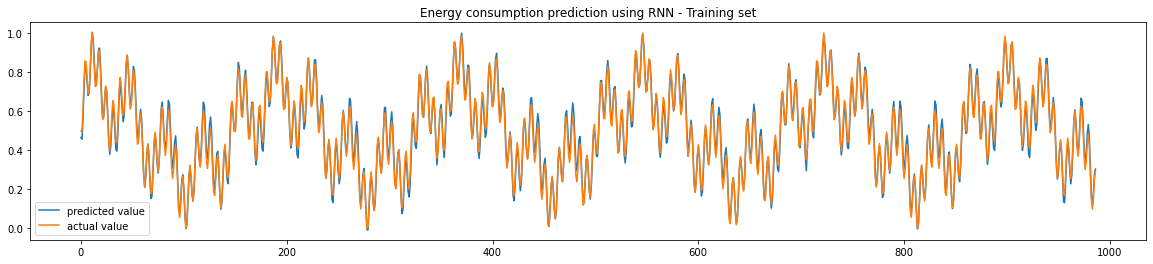

The mean squared error for Validation set is  0.00073277776
The root mean squared error for Validation set is  0.027069869
The mean absolute error for Validation set is  0.022125466


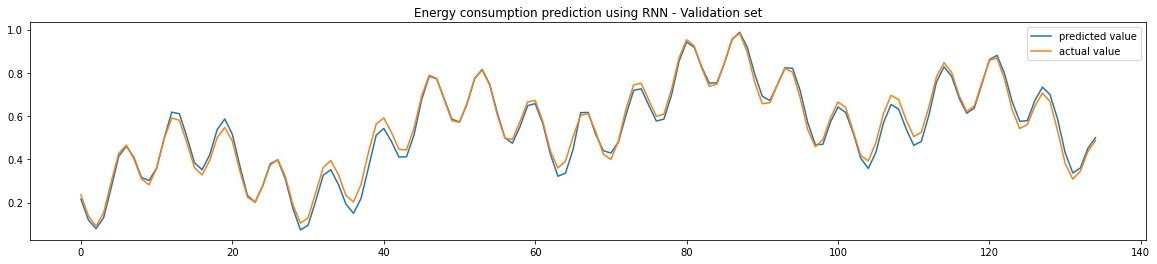

The mean squared error for Test set is  0.00086382707
The root mean squared error for Test set is  0.029390935
The mean absolute error for Test set is  0.024213182


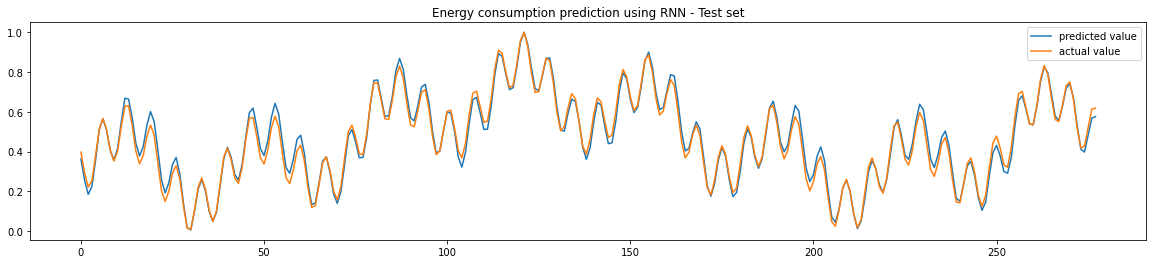

In [186]:
# display the results
set = ['Training set', 'Validation set', 'Test set']
true_label = [y_train_RNN, y_validation_RNN, y_test_RNN]
features = [X_train_RNN, X_validation_RNN, X_test_RNN]

for i in range(len(true_label)):
    y_pred = RNN_best(features[i])
    print("The mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred.detach().numpy(), true_label[i]))
    print("The root mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred.detach().numpy(), true_label[i], squared=False))
    print("The mean absolute error for {} is ".format(set[i]), mean_absolute_error(y_pred.detach().numpy(), true_label[i]))
    plt.figure(figsize=(20, 4))
    plt.plot(y_pred.detach().numpy(), label='predicted value')
    plt.plot(true_label[i], label='actual value')
    plt.title('Energy consumption prediction using RNN - ' + str(set[i]))
    plt.legend()
    plt.show()

In [187]:
# save the best MLP model
torch.save(RNN_best, 'RNN.pth')

# Part 4 - LSTM
### 4.1 LSTM without optimisation

In [168]:
# define a LSTM class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(LSTM, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state for first input with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.lstm(x, (h0, c0))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

Epoch: 10/100............. Loss: 0.0473
Epoch: 20/100............. Loss: 0.1252
Epoch: 30/100............. Loss: 0.0771
Epoch: 40/100............. Loss: 0.0556
Epoch: 50/100............. Loss: 0.0584
Epoch: 60/100............. Loss: 0.0429
Epoch: 70/100............. Loss: 0.0472
Epoch: 80/100............. Loss: 0.0397
Epoch: 90/100............. Loss: 0.0412
Epoch: 100/100............. Loss: 0.0376


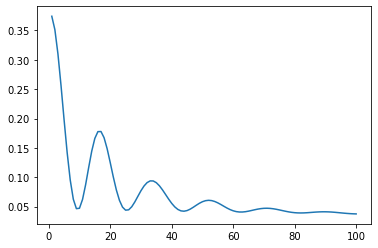

In [169]:
# Instantiate the model with hyperparameters
LSTM_model = LSTM(input_size=X.size(2), output_size=1, hidden_dim=40, num_layers=1)

# Define hyperparameters
n_epochs = 100
lr=0.01
momentum = 0.95

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(LSTM_model.parameters(), lr=lr, momentum=momentum)

LSTM_model.train()    # training mode

loss_list = []

# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    output = LSTM_model(X_train_RNN)
    output = output.to(device)

    loss = criterion(output, y_train_RNN)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    loss_list.append(loss.detach().numpy())

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

plt.plot(np.arange(1, 101), loss_list)
plt.show()



In [102]:
LSTM_model.eval()    # enter evaluation mode

y_pred = LSTM_model(X_validation_RNN)     # obtain predicted value
after_train = criterion(y_pred.squeeze(), y_validation_RNN.squeeze())    # compare predicted and target value using the criterion 
print('loss after training' , after_train.item())    

loss after training 0.02261611819267273


In [170]:
# test the loss on training set
y_pred_best = LSTM_model(X_validation_RNN)
print('The RMSE on validation set is ', mean_squared_error(y_pred_best.detach().numpy(), y_validation_RNN, squared=False))


The RMSE on validation set is  0.18965943


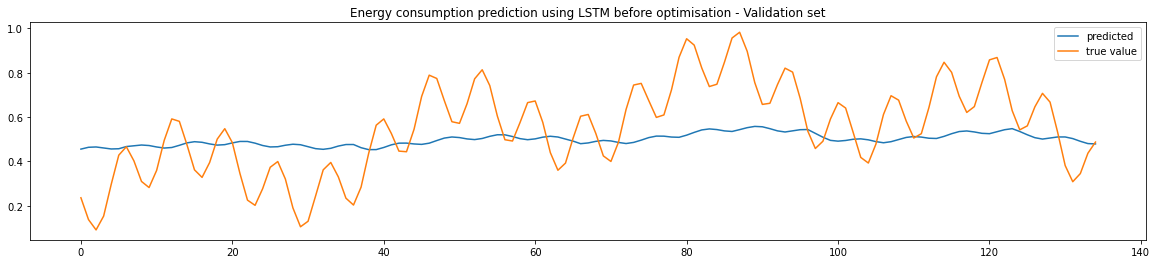

In [171]:
plt.figure(figsize=(20, 4))
plt.plot(y_pred_best.detach().numpy(), label='predicted')
plt.plot(y_validation_RNN, label='true value')
plt.title("Energy consumption prediction using LSTM before optimisation - Validation set")
plt.legend()
plt.show()

### 4.2 Grid search with cross validation

In [172]:
# new instance for RNN
LSTM_GS = LSTM(input_size=X.size(2), output_size=1, hidden_dim=40, num_layers=1)

net_LSTM = NeuralNetRegressor(module = LSTM_GS, train_split=False)  

params = {'lr': [0.01, 0.05, 0.1],
        'max_epochs': [20, 40],
        'optimizer': [torch.optim.SGD, torch.optim.Adam],
        'batch_size': [16, 32, 64]}

tt0 = time.time()       # start the timer

gs_LSTM = GridSearchCV(net_LSTM, params, scoring='neg_mean_squared_error', refit=True, cv=tscv, verbose=0)        # specify the grid search
gs_LSTM.fit(X_train_RNN, y_train_RNN)    # fit the data to the grid search

tt1 = time.time()       # stop the timer
print(gs_LSTM.best_params_)
print('Total time for grid search = ', str(tt1 - tt0))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.1540  0.1142
      2        0.0486  0.1165
      3        0.0424  0.1149
      4        0.0417  0.1138
      5        0.0413  0.1205
      6        0.0409  0.1227
      7        0.0405  0.1237
      8        0.0402  0.1084
      9        0.0398  0.1179
     10        0.0394  0.1146
     11        0.0391  0.1189
     12        0.0387  0.1285
     13        0.0383  0.1069
     14        0.0380  0.1100
     15        0.0376  0.1187
     16        0.0372  0.1112
     17        0.0369  0.1101
     18        0.0365  0.1202
     19        0.0361  0.1317
     20        0.0358  0.1322
  epoch    train_loss     dur
-------  ------------  ------
      1        0.1506  0.1271
      2        0.0476  0.1165
      3        0.0418  0.1296
      4        0.0412  0.1237
      5        0.0408  0.1140
      6        0.0404  0.1308
      7        0.0401  0.1152
      8        0.0397  0.1139
      9        0.0393  0.1392
     10   

In [173]:
print("Result of grid search returns the best model as {} with a mean squared error of {:.6f}".format(gs_LSTM.best_params_, -gs_LSTM.best_score_))

Result of grid search returns the best model as {'batch_size': 64, 'lr': 0.01, 'max_epochs': 40, 'optimizer': <class 'torch.optim.adam.Adam'>} with a mean squared error of 0.001293


In [174]:
# test the loss on validation set
y_pred_best = gs_LSTM.predict(X_validation_RNN)
mean_squared_error(y_pred_best, y_validation_RNN)  

0.00075262605

The mean squared error for Training set is  0.0006915678
The root mean squared error for Training set is  0.026297675
The mean absolute error for Training set is  0.021723755


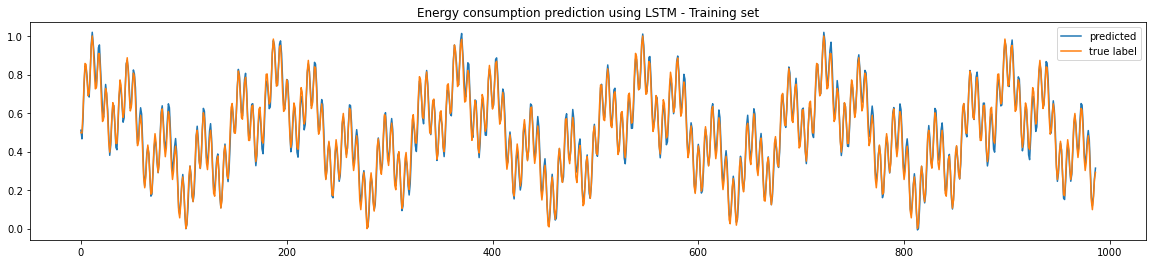

The mean squared error for Validation set is  0.00075262605
The root mean squared error for Validation set is  0.02743403
The mean absolute error for Validation set is  0.021543626


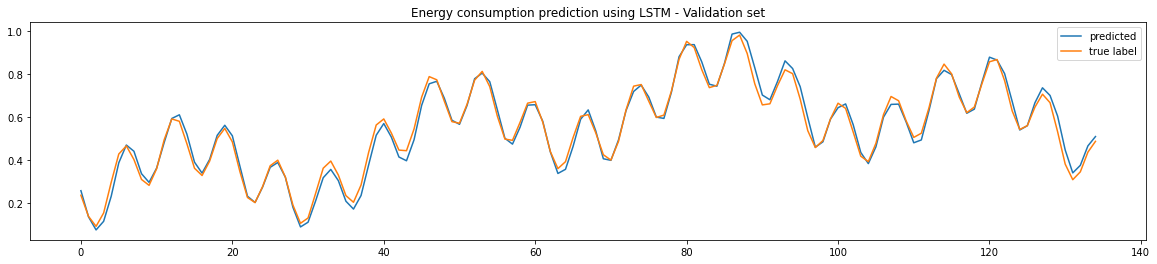

In [176]:
set = ['Training set', 'Validation set']
true_label = [y_train_RNN, y_validation_RNN]
features = [X_train_RNN, X_validation_RNN]

for i in range(len(true_label)):
    y_pred = gs_LSTM.predict(features[i])
    print("The mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i]))
    print("The root mean squared error for {} is ".format(set[i]), mean_squared_error(y_pred, true_label[i], squared = False))
    print("The mean absolute error for {} is ".format(set[i]), mean_absolute_error(y_pred, true_label[i]))
    plt.figure(figsize=(20, 4))
    plt.plot(y_pred, label='predicted')
    plt.plot(true_label[i], label='true label')
    plt.title('Energy consumption prediction using LSTM - ' + str(set[i]))
    plt.legend()
    plt.show()


## Part 5 - Test Run on the best trained models


In [7]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
# create a MLP class
# code from week 2 lab

class MLP(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.sigmoid(hidden)
        output = self.fc2(hidden)
        return output

# create RNN class
# code adopted from week 10 lab
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_size):
        super(RNN, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # RNN layers
        self.rnn = nn.RNN(input_size, hidden_dim, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out


In [9]:
# load the models
MLP = torch.load('MLP.pth')
RNN = torch.load('RNN.pth')

In [10]:
# load the dataset
test_data = pd.read_csv('test_data.csv')
test_data = test_data.iloc[:, 1:]   # delete the index column

In [11]:
# prepare the tensors for testing

# function to create list, with each element containing sequence_length of observations
def create_feature(input_data: pd.DataFrame, sequence_length):

    feature = []
    data_size = len(input_data)

    input_data = input_data.iloc[:, :-1]
    
    for i in range(data_size - sequence_length):
        
        sequence = input_data[i:i+sequence_length]

        feature.append(sequence)

    return feature

# function to create labels for each element of the create_feature list
def create_label(input_data: pd.DataFrame, target_column, sequence_length):

    labels = []
    data_size = len(input_data)

    for i in range(data_size - sequence_length):

        # sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        labels.append(label)

    return labels

# lag the data
SEQUENCE_LENGTH = 7
test_feature = create_feature(test_data, sequence_length=SEQUENCE_LENGTH)
test_label = create_label(test_data, "label", sequence_length=SEQUENCE_LENGTH)

# convert the test_feature list to tensor
X_test_MLP = torch.tensor(np.array(test_feature), dtype=torch.float)
# flatten the tensor
X_test_MLP = torch.flatten(X_test_MLP, start_dim=1)


# convert the test_label list to tensor
y_test_MLP = torch.FloatTensor(test_label)


# create tensor containing the lagged feature for test set 
X_test_RNN = np.array([np.array(xi) for xi in test_feature])      # convert the list of list to a numpy array
X_test_RNN = torch.Tensor(X_test_RNN)    # create the tensor

# create tensor for the label of test set 
y_test_RNN = torch.Tensor(np.array(test_label))  # convert the list of label to an numpy array, then to a tensor
y_test_RNN = torch.unsqueeze(y_test_RNN, 1)  # add a dimension of size one to the tensor


The mean squared error for is  0.002919002
The root mean squared error for is  0.05402779
The mean absolute error for is  0.044441137


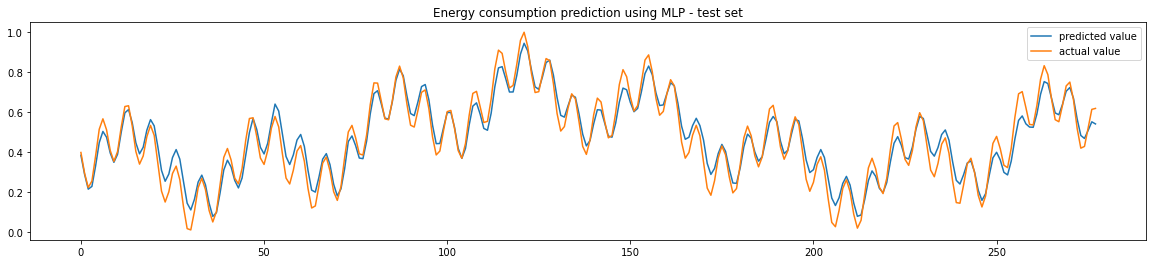

In [12]:
# run the models on the test set on MLP

y_pred = MLP(X_test_MLP)
print("The mean squared error for is ", mean_squared_error(y_pred.detach().numpy(), y_test_MLP))
print("The root mean squared error for is ", mean_squared_error(y_pred.detach().numpy(), y_test_MLP, squared=False))
print("The mean absolute error for is ", mean_absolute_error(y_pred.detach().numpy(), y_test_MLP))
plt.figure(figsize=(20, 4))
plt.plot(y_pred.detach().numpy(), label='predicted value')
plt.plot(y_test_MLP, label='actual value')
plt.title('Energy consumption prediction using MLP - test set')
plt.legend()
plt.show()

The mean squared error for is  0.00086382707
The root mean squared error for is  0.029390935
The mean absolute error for is  0.024213182


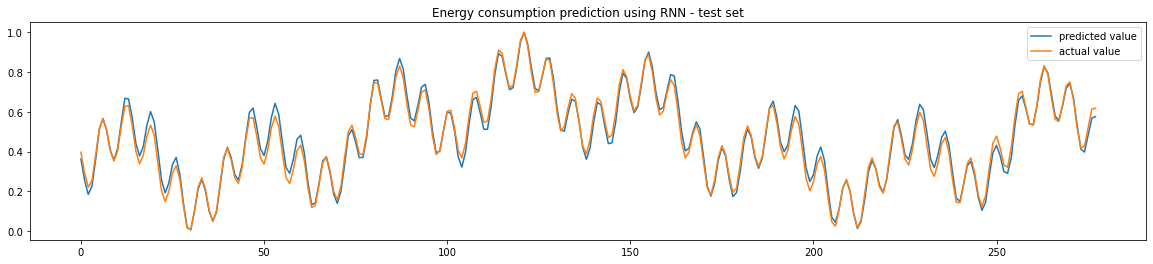

In [13]:
# run the models on the test set on RNN

y_pred = RNN(X_test_RNN)
print("The mean squared error for is ", mean_squared_error(y_pred.detach().numpy(), y_test_RNN))
print("The root mean squared error for is ", mean_squared_error(y_pred.detach().numpy(), y_test_RNN, squared=False))
print("The mean absolute error for is ", mean_absolute_error(y_pred.detach().numpy(), y_test_RNN))
plt.figure(figsize=(20, 4))
plt.plot(y_pred.detach().numpy(), label='predicted value')
plt.plot(y_test_MLP, label='actual value')
plt.title('Energy consumption prediction using RNN - test set')
plt.legend()
plt.show()